# Анализ бизнес-показателей приложения Procrastinate Pro+

В теле проекта: анализ данных о посещениях новыми пользователями приложения Procracstinate Pro+ в период с 2019-05-01 по 2019-10-27, об их покупках за этот период, а так же о статистике рекламных расходов. Запрос компании: выяснить причину неэффективной рекламы и сформулировать предложения для оптимизации расходов и привлечения новых пользователей.

В первую очередь, мы познакомимся с данными и подготовим их для анализа, далее сформулируем основные функции для расчетов необходимых бизнес-показателей, сформируем когортные группы и визуализируем полученные результаты. Так же выясним, в какие рекламные источники вкладывались средства, из каких регионов привлекались пользователи и какими устройствами они пользуются, окупаются ли вложения в целом и по каждому исследуемому признаку.

## Подготовка данных
Для начала загрузим и изучим предоставленные данные, приведем их к нужному типу и подготовим к дальнейшему анализу.

**Информация о данных:**

*visits_log_short* (лог сервера с информацией о посещениях сайта):
* User Id — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Session start — дата и время начала сессии
* Session End — дата и время окончания сессии
* Channel — идентификатор рекламного источника, из которого пришел пользователь
* Region - страна пользователя

*orders_log_short* (информация о заказах):
* User Id — уникальный id пользователя, который сделал заказ
* Event Dt — дата и время покупки
* Revenue — выручка

*costs_info_short* (информация о закупах рекламы)
* Channel — идентификатор рекламного источника
* Dt — дата
* Costs — затраты на этот рекламный источник в этот день

In [127]:
# импорт библиотек
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [128]:
costs = pd.read_csv('datasets\\costs_info_short.csv') # файл с информацией о закупе рекламы 
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [129]:
orders = pd.read_csv('datasets\\orders_info_short.csv') # информация о покупках
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [130]:
visits = pd.read_csv('datasets\\visits_info_short.csv') # информация о активности пользователей
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Все столбцы названы как попало, сделаем их вид более структурированным, и разберемся с датами.

In [131]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values] # переименовываем столбцы
costs.columns = ['dt', 'channel', 'costs']
orders.columns = ['user_id', 'event_dt', 'revenue']

In [132]:
# переводим формат даты в правильный тип

costs['dt'] = pd.to_datetime(costs['dt']).dt.date
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [133]:
print(costs.info()) # общая информация о данных
print(visits.info())
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [134]:
print(f'Дубликатов в таблице costs: {costs.duplicated().sum()}')
print(f'Дубликатов в таблице visits: {visits.duplicated().sum()}')
print(f'Дубликатов в таблице orders: {orders.duplicated().sum()}')

Дубликатов в таблице costs: 0
Дубликатов в таблице visits: 0
Дубликатов в таблице orders: 0


Пропусков нет, столбцы красивые, идем дальше.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

В этом пункте определимся с основными функциями для расчетов:

In [135]:
def get_profiles(   # функция для создания пользовательских профилей
    sessions,
    orders,
    ad_costs
): 

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # стоимость органических профилей переводим в нуль
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [136]:
def get_retention(     # функция для расчета удержания пользователей
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # таблица удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # таблица динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [137]:
def get_conversion(      # функция расчета конверсии 
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # таблица конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # таблица динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

In [138]:
def get_ltv(       # функция для расчета показателей LTV, ROI
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [139]:
def plot_retention(retention, retention_history, horizon, window=7):  # функция для построения графиков удержания

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    plt.tight_layout()
    plt.show()

In [140]:
# функция для построения графиков конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [141]:
# функция сглаживание фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 


# функция для построения графиков LTV, ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Пользовательские профили

Воспользуемся функцией **get_profiles** и выведем всю информацию о первом  посещении каждого пользователя, агрегированные данные в дальнейшем понадобятся для когортного анализа.

In [142]:
profiles = get_profiles(visits, orders, costs) # создаем пользовательские профили
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [143]:
print(profiles['first_ts'].min()) # минимальная
print(profiles['first_ts'].max()) # и максимальная дата привлечения

2019-05-01 00:00:41
2019-10-27 23:59:04


Данные охватывают промежуток времени с 1 мая 2019 по 27 октября 2019 года.

### Анализ пользовательских профилей по дополнительным признакам

Основная характеристика, которая определяет наших пользователей - это дата его первого посещения. Но так же есть и дополнительные - это **регион, используемое устройство и рекламный источник привлечения**. Пройдемся по каждому из них.

In [144]:
def pivot_info(value=[]): # напишем функцию для создания сводной таблицы по каждому из признаков
    df = profiles
    if 'channel' in value:
        df = profiles.query('channel != "organic"')
    pivot = (
        df
        .groupby(value)
        .agg({'user_id': 'nunique', 'payer': 'mean'})
        .sort_values(by='payer', ascending=False)
    )
    return pivot

In [145]:
pivot_info('region') # таблица по регионам

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


В исследовании участвуют четыре региона, из них больше всего пользователей пришло из США, затем из Великобритании, Франции и Германии по убыванию. По доле платящих пользователей рейтинг почти не меняется: США привлек 6,9% платежеспособной аудитории. Хоть пользователей из Германии представлено меньше всего, по потенциалу прибыли она вышла на второе место: доля 4,1%.

In [146]:
pivot_info('device') # таблица по девайсам

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Доля платящих пользователей выше всего у яблочной продукции: 6,3% у юзеров Mac и 6,2% у айфонов, а вот ПК имеет самую низкую долю. Пользователи с айфоном так же занимают треть всей аудитории: более 50 тысяч новых пользователей за исследуемый период.

In [147]:
pivot_info('channel') # таблица каналов привлечения

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


Для рекламы использовалось десять различных источников привлечения покупателей, среди них есть как явные лидеры, так и аутсайдеры. Наибольшую долю уникальных и платящих пользователей принес источник **FaceBoom**, еще два источника: **AdNonSense** и **lambdaMediaAds**, пересекли границу в десять процентов. **OppleCreativeMedia** остается на последнем месте, его доля привлечения платящей аудитории почти равна аналогичному привлечению из органических источников. 

In [ ]:
#(profiles
 #.pivot_table(index='dt', columns='channel', values='user_id', aggfunc='nunique')
#.plot(figsize=(15, 7), grid=True)
#)
#plt.title('Динамика привлечения новых пользователей из рекламных каналов')
#plt.xlabel('Дата привлечения')
#plt.ylabel('Количество новых пользователей')
#plt.show()

Для рекламы использовалось десять различных источников привлечения покупателей, среди них есть как явные лидеры, так и аутсайдеры. Наибольшую долю уникальных и платящих пользователей принес источник **FaceBoom**, еще два источника: **AdNonSense** и **lambdaMediaAds**, пересекли границу в десять процентов. **OppleCreativeMedia** остается на последнем месте, его доля привлечения платящей аудитории почти равна аналогичному привлечению из органических источников. 

Изучив пользовательские профили, можно сделать несколько промежуточных выводов. 
* *Во-первых*, из всех рекламных источников только три из них имеют высокую долю привлечения платящих пользователей; стоит заметить, что у двух рекламных платформ **AdNonSense** и **lambdaMediaAds** в целом самое маленькое количество уникальных пользователей: можно предположить что эти площадки привлекают более качественную аудиторию, но все зависит от дальнейших расчетов удержания и от затрат на рекламу.

* *Во-вторых*, платящие пользователи в основном пользуются устройствами Mac и iPhone, а две трети всей аудитории были привлечены из США. Стоит обратить вниманию также на немецкий регион, он на втором месте по доле платящих пользователей. 

* *В-третьих*, есть лидеры по количеству привлеченных пользователей: **FaceBoom** и **Tip Top**, первый находится так же в топе по доле платящей аудитории (возможно, как раз за счет общего числа людей), а вот второй не входит даже в первую тройку, это стоит взять на заметку.

## Маркетинг

In [149]:
sum = costs['costs'].sum() # общая сумма затрат на рекламу
print(f'С 1 мая по 27 октября 2019 года было потрачено {sum:.2f} рублей на рекламу.')

С 1 мая по 27 октября 2019 года было потрачено 105497.30 рублей на рекламу.


Ни прибавить, ни отнять. Интересно, как эти деньги были распределены по разным источникам.

In [150]:
(costs   # затраты на каждый рекламный источник
 .pivot_table(index='channel', values='costs', aggfunc='sum')
 .sort_values(by='costs', ascending=False)
)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Лидер по закупу - **TipTop** и **FaceBoom**, отрыв от остальные рекламных площадок просто колоссальный.

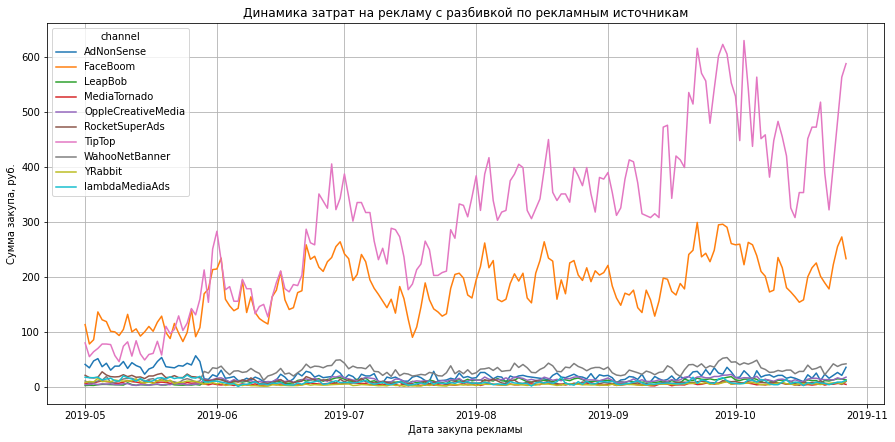

In [151]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').plot(figsize=(15,7), grid=True)
plt.xlabel('Дата закупа рекламы')
plt.ylabel('Сумма закупа, руб.')
plt.title('Динамика затрат на рекламу c разбивкой по рекламным источникам')
plt.show()
# таблица затрат на каждый источник ежедневно

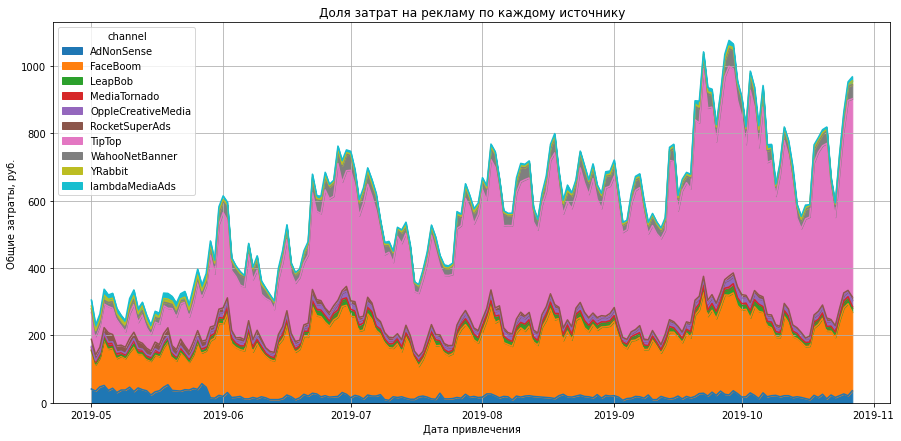

In [152]:
(costs # доля затрат на каждый рекламный источник
 .pivot_table(index='dt',columns='channel', values='costs',  aggfunc='sum')
 .plot.area(figsize=(15, 7), grid=True)
)
plt.title('Доля затрат на рекламу по каждому источнику')
plt.xlabel('Дата привлечения')
plt.ylabel('Общие затраты, руб.')
plt.show()

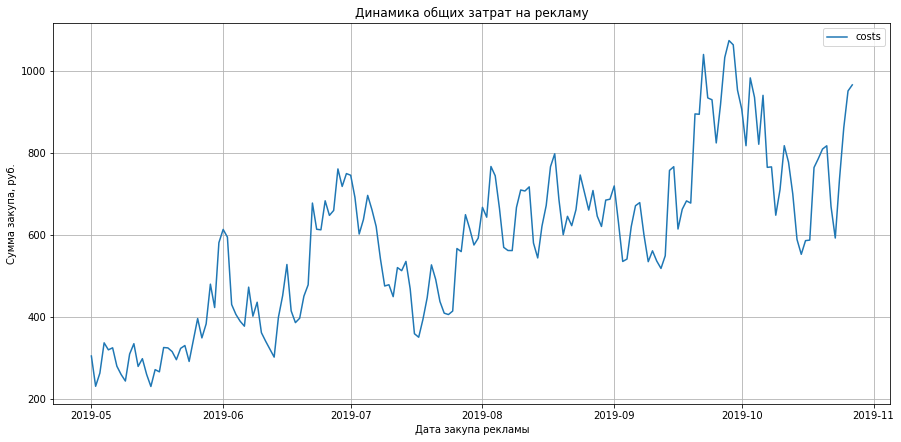

In [153]:
costs.groupby('dt').agg({'costs': 'sum'}).plot(figsize=(15,7), grid=True) # как выросли затраты на маркетинг
plt.xlabel('Дата закупа рекламы')
plt.ylabel('Сумма закупа, руб.')
plt.title('Динамика общих затрат на рекламу')
plt.show()

Как мы видим, рекламные затраты в октябре выросли более чем в два раза по сравнению с майскими показателями. График выше показывает, что в основном средства вкладывались в **TipTop** и **FaceBoom**, в остальных источникам закуп остается стабильным.

In [154]:
cac = (profiles   # расчет cac на одного пользователя
       .query('channel != "organic"')
       .groupby('channel')
       .agg({'acquisition_cost': 'sum', 'user_id':'count'})
       .rename(columns={'acquisition_cost': 'sum','user_id':'count'})
        )
cac['cac'] = cac['sum']/cac['count']
cac.sort_values(by='cac', ascending=False)

,sum,count,cac
channel,,,
TipTop,54751.30,19561,2.799003
FaceBoom,32445.60,29144,1.113286
AdNonSense,3911.25,3880,1.008054
lambdaMediaAds,1557.60,2149,0.724802
WahooNetBanner,5151.00,8553,0.602245
RocketSuperAds,1833.00,4448,0.412095
OppleCreativeMedia,2151.25,8605,0.250000
YRabbit,944.22,4312,0.218975
MediaTornado,954.48,4364,0.218717


В этих же вышеупомянутых площадках цена одного клиента выходит дороже прочих рекламодателей. В особенности у **TipTop**: деньги вложены большие, а выхлоп не самый огромный, стоимость привлечения почти 3 рубля. Дорого, если посмотреть на соседний FaceBoom. Есть предположение, что вкладываться в TipTop было не очень выгодно.

In [155]:
profiles['acquisition_cost'].mean() # средний САС для всего проекта на одного пользователя

0.7032778251826568

Средняя стоимость в 1,12 рубля лишь доказывает предыдущий вывод. Надо бы разобраться с этим TipTop.

Что мы выяснили: из 105 тысяч рублей половина бюджета была вложена в рекламу в **TipTop**, треть - в **FaceBoom** и остатки - в 8 других площадок. При средней стоимости пользователя в 1,12 рубля закуп у **TipTop** выходит слишком дорогим. С мая рекламные расходы начали увеличиваться с 300 рублей почти до 1000 рублей ежедневно. Кажется, что проблема кроется в прожорливой рекламной площадке. Приступим к анализу окупаемости рекламы и там уже найдем источник проблем. 

## Оценка окупаемости рекламы для привлечения пользователей

### Расчет общей окупаемости рекламы

Для когортного анализа определим момент анализа - 1 ноября 2019 года. Горизонтом анализа будет 14 дней: именно за такой период после привлечения пользователи должны окупаться. 

Предлагаю для дальнейшего анализа не использовать данные об органических пользователях, так как они так же приобретают продукты, но на их привлечение компания не тратилась. Оставим только привлеченных юзеров.

In [156]:
horizon_days = 14  # определяемся с горизонтом анализа
observation_date = datetime(2019,11,1).date()
profiles = profiles.query('channel != "organic"')

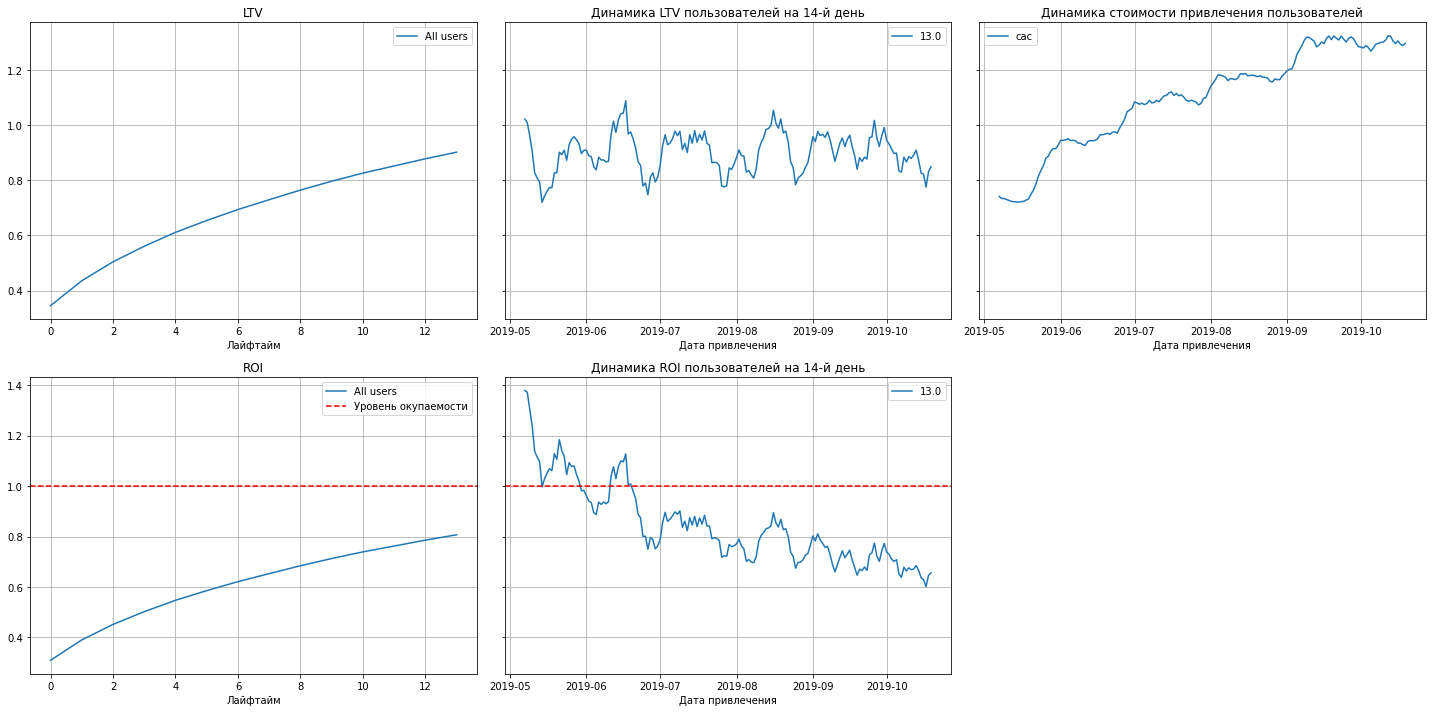

In [157]:
# общая окупаемость рекламы
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

# Строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

Итак, всё очень плохо. Реклама **не** окупается, ROI по итогам 14 дней чуть выше 80% процентов, LTV стабилен и держится в одном разрезе показателей, а вот CAC ежемесячно растет, что мы уже отмечали ранее. Динамика ROI падает в обратной пропорции к рекламным затратам, и когорты от октября окупаются уже всего на 60%. Очевидно, что подъем CAC увеличивает стоимость клиента и повышает его планку окупаемости. (Пока все подтверждает наши догадки про TipTop, но только ли в рекламном источнике кроется проблема? Надо проанализировать когорты по дополнительным признакам).  

### Окупаемость рекламы по источникам привлечения

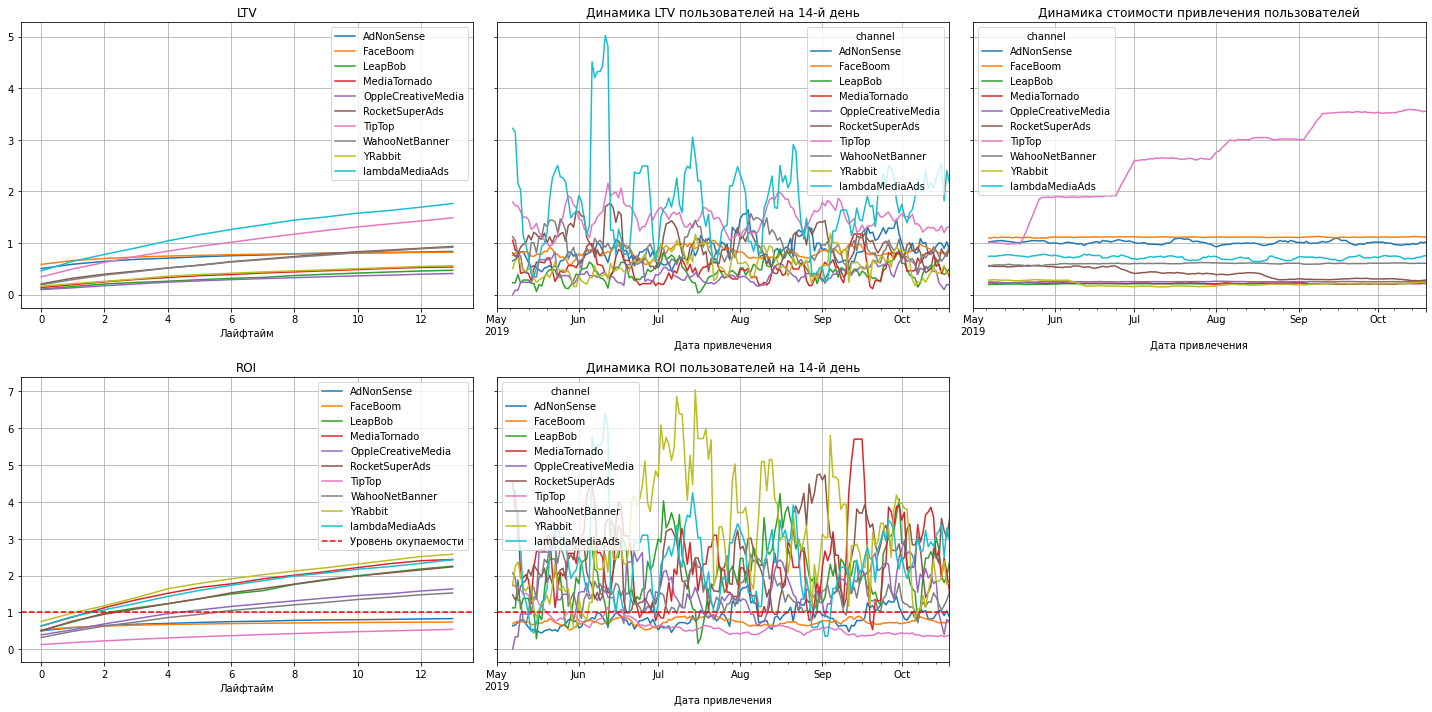

In [158]:
# окупаемость рекламы по источникам привлечения
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=['channel'])

# Строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

А вот и реальное доказательство; компания ежемесячно повышала платежи за рекламу в **TipTop**, но вот ROI за две недели самый низкий из всех источников и до порога окупаемости не дотягивает. К аутсайдерам так же присоединяется рекламодатель **AdNonSense** и **FaceBoom** (только вот мы помним, что хоть и затраты на него так же росли, CAC стабилен, значит, количество привлеченных пользователей растет ежемесячно, но не окупается, видимо аудитория с него приходит не самая качественная). Результаты феноменально контрастируют с динамикой ROI, например, **YRabbit**: в лучшие месяцы вложения окупались почти в семь раз. Или **lambdaMediaAds** приводит хороших и качественных пользователей с высоким LTV и отлично выходит в плюс уже на 3 день.

### Окупаемость рекламы по регионам

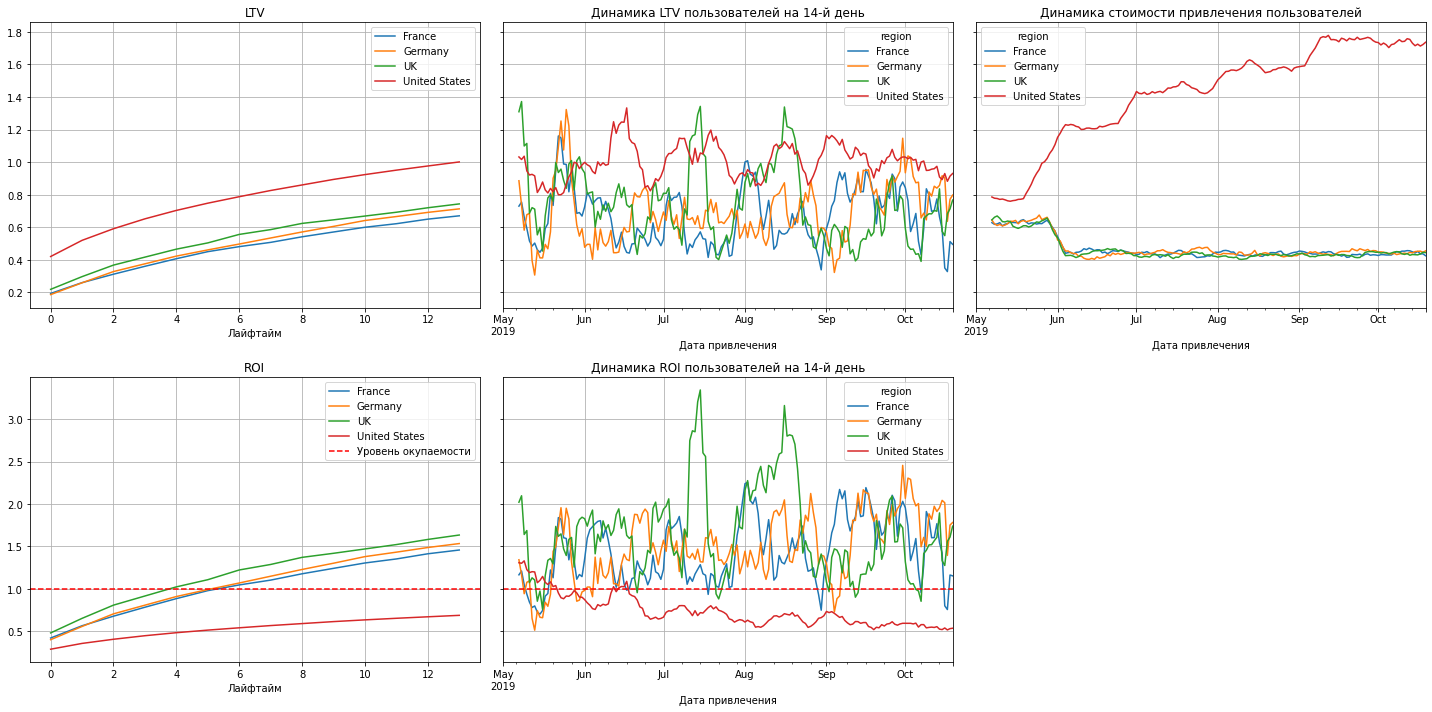

In [159]:
# окупаемость рекламы по региону
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=['region'])

# Строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

США - ROI буквально на дне, стоимость привлечения сильно растет, а вот у всех остальных стран она даже подешевела после мая и стабильна. Кажется, наш **TipTop** привлекал именно американских пользователей, два фактора могут быть взаимосвязаны. Остальные страны окупаются хорошо, но за счет того, что пользователей из сша в разы больше, общая динамика удручает. Динамика LTV американского региона выше, они платят больше (но их самих больше, к слову), однако это не сопоставимо с рекламными расходами.

Выходит, наша болевая точка конкретизируется: это американский регион и закуп рекламы у TipTop. Стоит еще проверить результаты по устройствам, и далее искать причину проблем.

### Окупаемость рекламы по девайсам

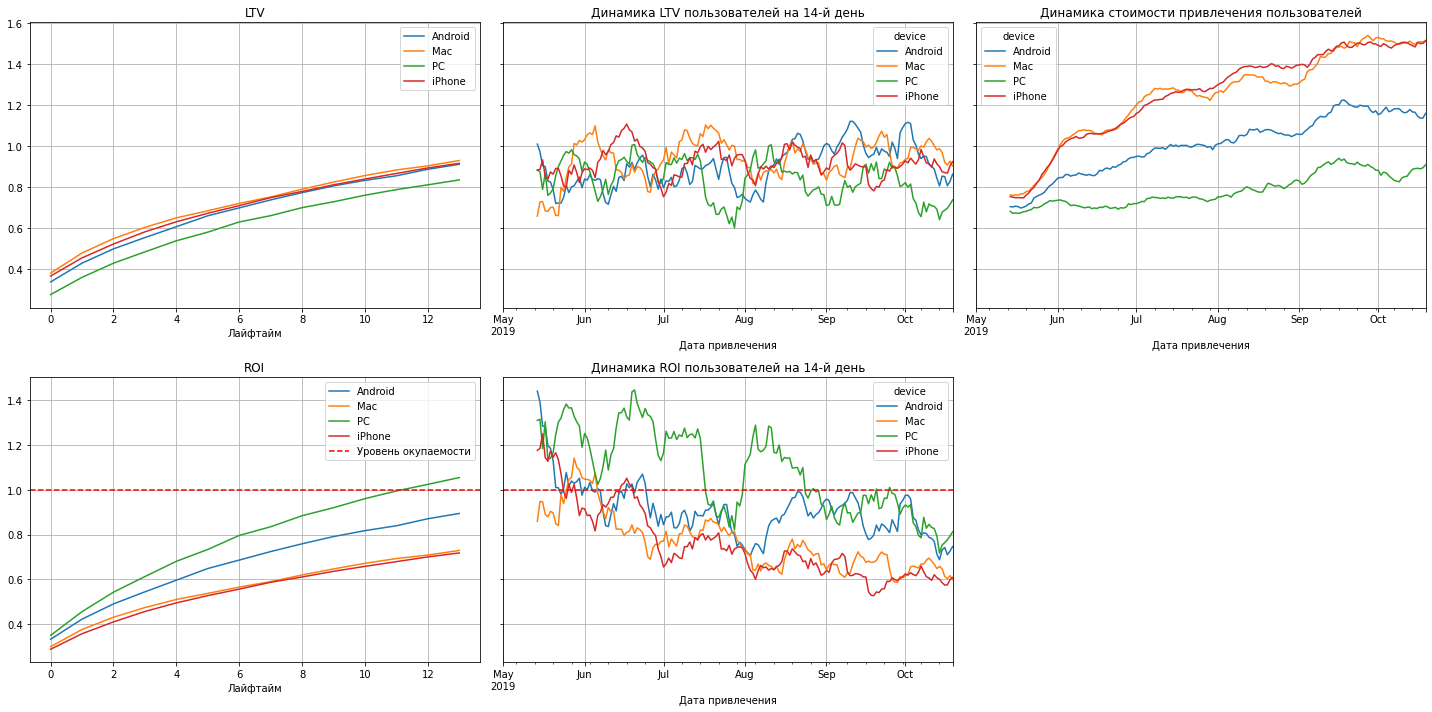

In [160]:
# показатели окупаемости по используемым устройствам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=['device']) # расчет лтв, рои по девайсам

# Строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14) 

Окупаются к концу второй недели только пользователи ПК, и стоимость на одного юзера дешевле, видимо только за счет этого выходит положительная динамика, однако общая тенденция к снижению к 14 дню одинакова для всех устройств. В октябре показатель ROI на 14 день от 60 до 80%. Значит, причина не в девайсах, а в расходах на определенные рекламные источники в США.

In [161]:
# сводная таблица по рекламному источнику и количеству привлеченных регионов
profiles.pivot_table(index='channel', columns='region', values='user_id', aggfunc='nunique')

region,France,Germany,UK,United States
channel,,,,
AdNonSense,1366.0,1219.0,1295.0,NaN
FaceBoom,NaN,NaN,NaN,29144.0
LeapBob,2988.0,2519.0,3046.0,NaN
MediaTornado,NaN,NaN,NaN,4364.0
OppleCreativeMedia,2991.0,2562.0,3052.0,NaN
RocketSuperAds,NaN,NaN,NaN,4448.0
TipTop,NaN,NaN,NaN,19561.0
WahooNetBanner,2971.0,2579.0,3003.0,NaN
YRabbit,NaN,NaN,NaN,4312.0


Эта таблица проясняет очень многое: например, как мы и думали, компании **TipTop** и **FaceBoom** проводили рекламу приложения только в американскому регионе, это раз. Два: реклама в целом разделена на, скажем, европейскую часть и США. Три: связав два факта, мы можем подтвердить нашу теорию с проблемами рекламы в Америке на конкретных рекламных площадках.

## Конверсия и удержание пользователей

### Конверсия и удержание с разбивкой по регионам

Болевую точку мы нашли, теперь стоит узнать причину низкой окупаемости пользователей США: конверсия или удержание. Для полной картины стоит пройтись так же по всем исследуемым характеристикам.

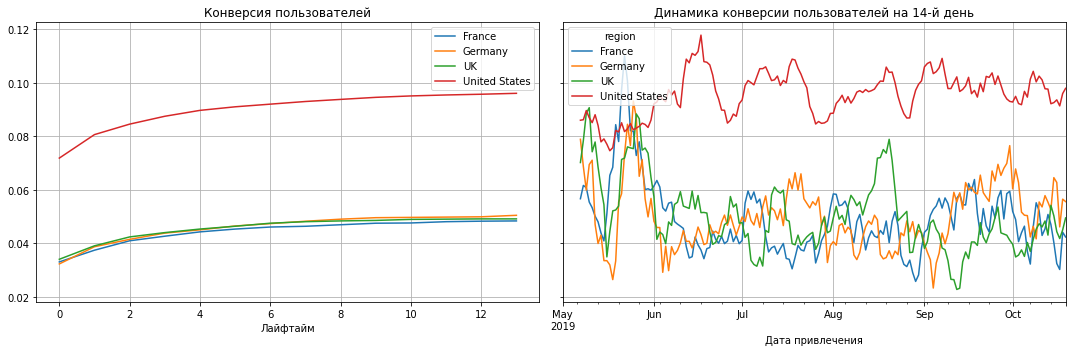

In [162]:
# конверсия по региону
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon_days)

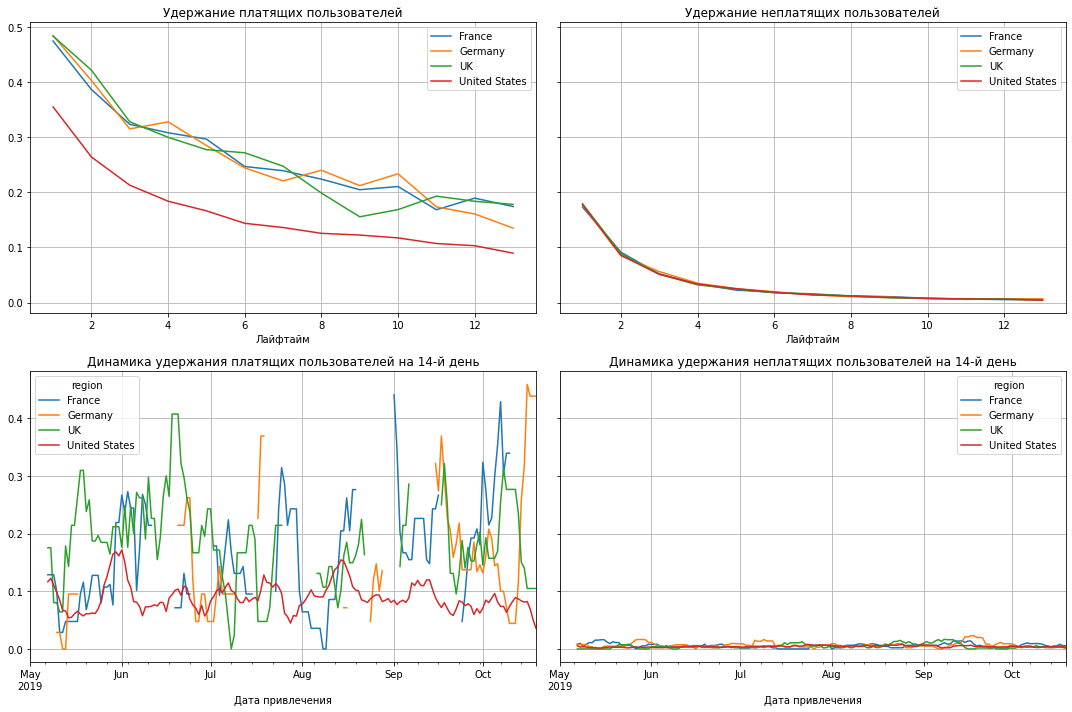

In [163]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['region'])

plot_retention(retention, retention_history, horizon_days) # удержание по региону

Очень занимательно: американские пользователи отлично конвертируются, но вот удержание у них сильно страдает. Как будто людей много, и они отлично делают одну покупку, но более не возвращаются, а бесконечный закуп рекламы только увеличивает стоимость каждого нового клиента. Ситуация в других регионах абсолютно противоположна региону американскому. Интересно, одинаковый ли интерфейс и наполненность приложения для разных регионов?  

### Конверсия и удержание с разбивкой по каналам привлечения

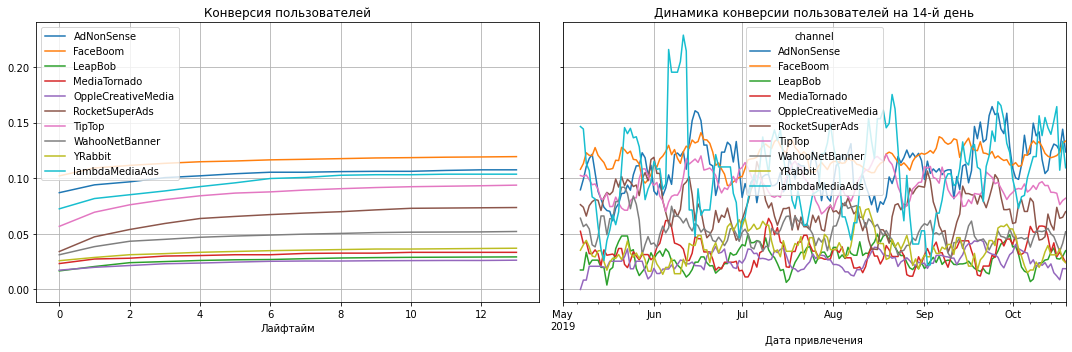

In [164]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon_days) # конверсия по каналам привлечения

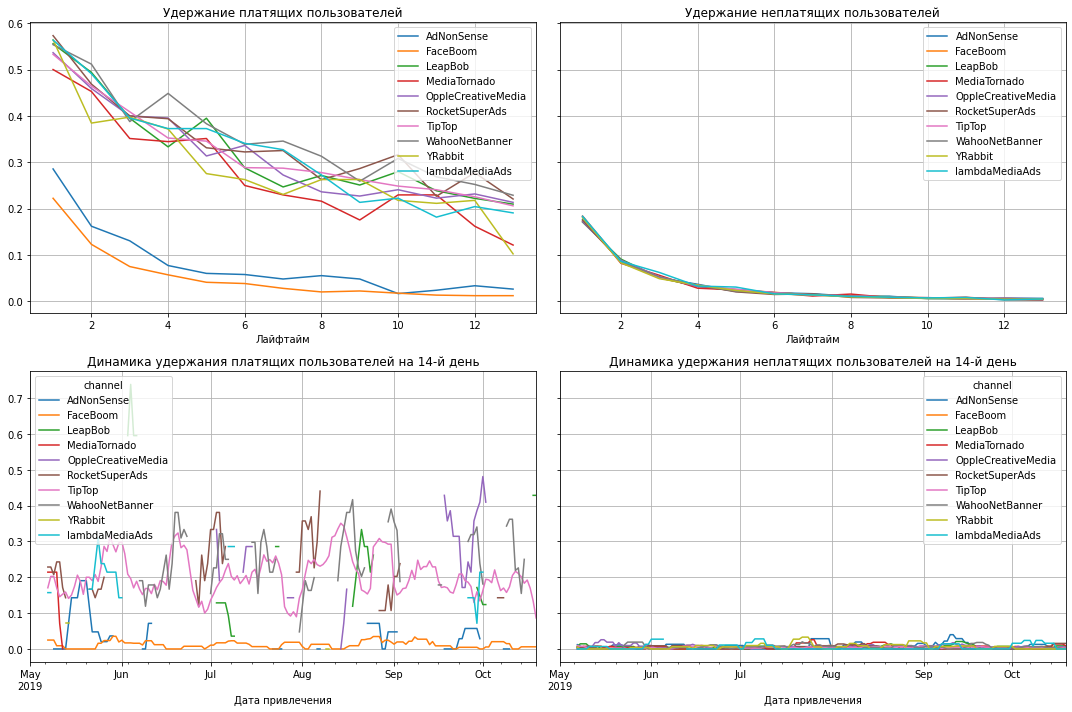

In [165]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['channel'])

plot_retention(retention, retention_history, horizon_days) # удержание по каналам привлечения

Проблемы вылезли так же со знакомым **FaceBoom**: удержание к концу второй недели можно сказать, что практически нулевое. А ведь он находится на втором месте по количеству привлеченных пользователей, как мы помним. **AdNonSense** такой же грустный, только в Европе. Хотя оба конвертируются очень хорошо, опять таки... И вот у нас уже три проблемных рекламных источника.

### Конверсия и удержание с разбивкой по девайсам

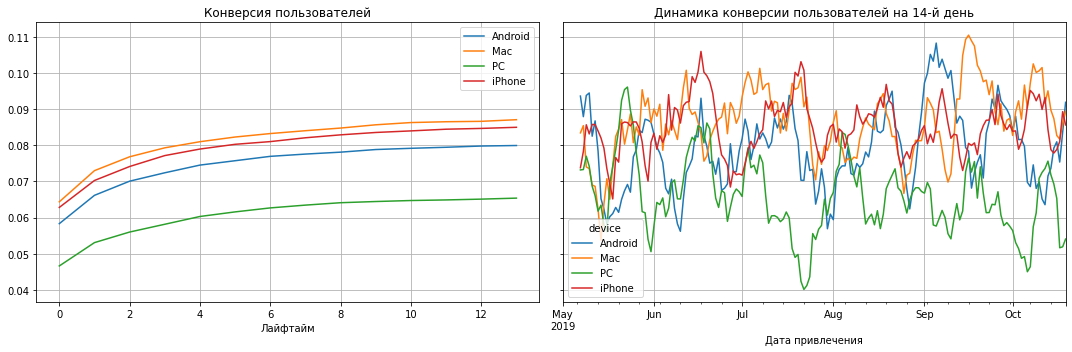

In [166]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon_days) # конверсия девайсам

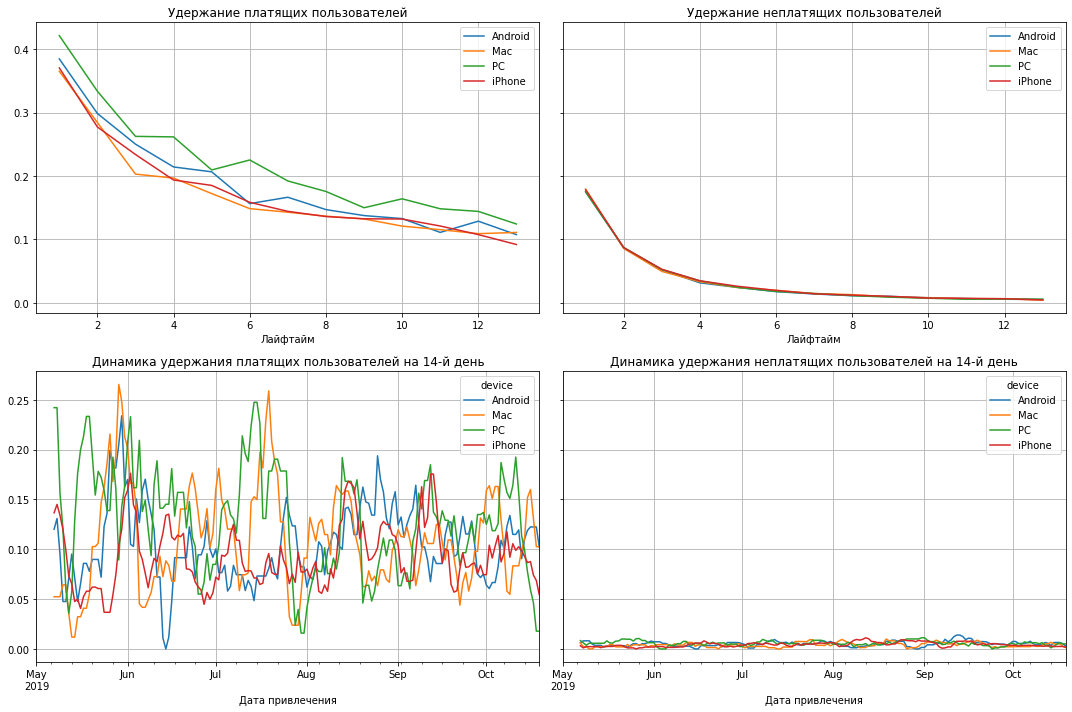

In [167]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['device'])

plot_retention(retention, retention_history, horizon_days, window=7) # удержание по девайсам

По устройствам, к слову, все более-менее ожидаемо: стоит в будущем задуматься об увеличении конверсии пользователей ПК, но в разрезе нашей актуальной проблемы об окупаемости рекламы, здесь этот вопрос влияет мало. По удержанию все девайсы находится примерно на одном уровне.

Итак, что мы выяснили: у США действительно есть большие проблемы с удержанием пользователей: они неплохо конвертируются, но с учетом всех затрат этого показателя недостаточно. Не хватает данных о дополнительных событиях пользователей, чтобы принять или опровергнуть гипотезу о технических проблемах. Основываясь на тех данных, что у нас есть, пока можно только предположить, что дело в некачественной рекламе.

Рекламные источники **FaceBoom, adNoNSense** показывают так же плохие результаты по удержанию покупателей. Плохо конвертируются пользователи ПК, что тоже отражается на общей динамике прибыли компании.

## Выводы

Итак, подведем итоги по проведенной работе:
1. Во-первых, проведена предобработка данных: устранены неточности в столбцах и изменен тип даты в таблицах. Все это было необходимо для будущего когортного анализа. Исследуемый период охватывает данные с 1 мая 2019 по 27 октября 2019 года.


2. Во-вторых, мы проанализировали пользовательские профили и выяснили, что распределение пользователей по регионам неравномерное; 
    * **две трети пользователей из американского региона (66,6%), он же лидер по привлечению платежеспособной аудитории - 6,9%.** Весь закуп рекламы в соответствии с этим направлен именно на США.
    *  **82,6%** всего бюджета были потрачены на рекламу в TipTop и FaceBoom, причем затраты увеличивались ежемесячно в сравнении с другими источниками; именно с помощью этих компаний привлекаются американские пользователи.
    

3. В-третьих, анализ юнит-экономики выявил слабые места всей рекламной компании:
    * Основное и самое главное: реклама **не** окупается. ROI за две недели не превышает **80%**, а на 14 день и вовсе имеет отрицательную динамику.
    * CAC пользователя за исследуемый период увеличился с **0,7 рублей до 1,3**, при этом показатель LTV стабилен на протяжении всего периода.
    * Три основных рекламных источника - **TipTop, FaceBoom, AdNonSense**, - не окупаются, в то время как остальные выходят в плюс уже к середине первой недели. 
    * США является самым проблемным регионом: показатель ROI в динамике на 14 день к октябрю опустился до уровня **50%**. 
    
    
4. В-четвертых, расчеты конверсии и удержания пользователей дополнили наши наблюдения: американские пользователи конвертируются в два раза лучше европейских, однако их удержание к 14 дню всего лишь 1%, что ниже чем у других регионов. Так же страдает удержание рекламного источника FaceBoom.


5. Таким образом, основной причиной неэффективности рекламы является *нерезультативное вложение средств в американском регионе с привлечением рекламных источников TipTop и FaceBoom*: при постоянном увеличении бюджета растет показатель CAC одного пользователя, но при стабильном LTV итоговые затраты не окупаются количеством новых клиентов, так как страдает их качество. 


6. При хорошем показателе конверсии в США (почти 10% против 5% в Европе) стоит задуматься над удержанием пользователей и увеличении "пожизненной ценности" клиентов, сейчас они обходятся компании слишком дорого.